# Import Important libraries and Modules

In [1]:
import sys
import os
import pandas as pd
from datetime import timedelta
import math
import numpy as np
import warnings
warnings.filterwarnings('ignore')
sys.path.append(os.path.abspath(os.path.join('../Scripts')))

from sequential_testing_helper import Sequential_AB_Helper
helper = Sequential_AB_Helper()


# Read Data

In [2]:
#read the data
data=pd.read_csv('../data/AdSmartABdata.csv')
data.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


# Transform Data In to Bernoli Series

In [3]:
def transform_data(df):
    '''
      segment data into exposed and control groups
      consider that SmartAd runs the experment hourly, group data into hours. 
          Hint: create new column to hold date+hour and use df.column.map(lambda x:  pd.Timestamp(x,tz=None).strftime('%Y-%m-%d:%H'))
      create two dataframes with bernouli series 1 for posetive(yes) and 0 for negative(no)
        Hint: Given engagement(sum of yes and no until current observation as an array) and success (yes countas an array), the method generates random binomial distribution
            #Example
               engagement = np.array([5, 3, 3])
               yes = np.array([2, 0, 3])       
             Output is "[1] 1 0 1 0 0 0 0 0 1 1 1", showing a binary array of 5+3+3 values
             of which 2 of the first 5 are ones, 0 of the next 3 are ones, and all 3 of
             the last 3 are ones where position the ones is randomly distributed within each group.
    '''
    clean_data = df[df['yes'] == 1].append(df[df['no'] == 1]) 
    #Segmenting data into exposed and control groups
    exposed_group = clean_data[clean_data['experiment'] == 'exposed']
    control_group = clean_data[clean_data['experiment'] == 'control']


    #Grouping Data using hours
    control_group['hour'] = control_group['hour'].astype('str')
    control_group['date'] = control_group['date'].astype('str')
    control_group['date+hour'] = pd.to_datetime(control_group['date'] + " " + control_group['hour'] + ":00:00")
    control_group['date+hour'] = control_group['date+hour'].map(lambda x:  pd.Timestamp(x, tz=None).strftime('%Y-%m-%d:%H'))

    exposed_group['hour'] = exposed_group['hour'].astype('str')
    exposed_group['date'] = exposed_group['date'].astype('str')
    exposed_group['date+hour'] = pd.to_datetime( exposed_group['date'] + " " + exposed_group['hour'] + ":00:00")
    exposed_group['date+hour'] = exposed_group['date+hour'].map( lambda x:  pd.Timestamp(x, tz=None).strftime('%Y-%m-%d:%H'))
    #Generating engagment and yes array based on date+hour column grouping
    control_counts = control_group.groupby('date+hour').agg({'yes': 'sum', 'no': 'count'})
    #Generate bernouli series
    control_group_bernouli = helper.bernouli_constructor(control_counts['no'],control_counts['yes'])

    exposed_counts = exposed_group.groupby('date+hour').agg({'yes': 'sum', 'no': 'count'})

    #Generate bernouli series
    exposed_group_bernouli = helper.bernouli_constructor(exposed_counts['no'],exposed_counts['yes'])

    data_stream = (control_group_bernouli, exposed_group_bernouli)

    return data_stream

In [4]:
data_stream = transform_data(data)
# data_stream

# Conditional SPRT Class

In [5]:
class ConditionalSPRT:
    def __init__(self,exposed,control,odd_ratio,alpha=0.05,beta=0.10,stop=None):
        self.x = exposed
        self.y = control
        self.t1 = odd_ratio
        self.alpha = alpha
        self.beta = beta
        self.stop = stop
    def ConditionalSPRT(self,x,y,t1,alpha=0.05,beta=0.10,stop=None):
            """
               #
              # Meeker's SPRT for matched `x` (treatment) and `y` (control), 
              # both indicator responses, likelihood ratio t1, error rates alpha and beta,
              # and (optionally) truncation after trial stop.
              #
              # The return variable contains these elements:
              #(outcome,n, k,l,u,truncated,truncate_decision,x1,r,stats,limits)
              # * outcome:   "continue," "reject null," or "accept null".
              # * n: number observation used for the decsion
              # * k:     Index at which the outcome decision was made (or NA)
              # * l:     lower critical point
              # * u:     upper critical point
              # * truncate_decision: The approximate decision made after truncate point
              # * truncated: If the test was truncated, the value of `n.0`; NA otherwise
              # * x1:       Original data `x`, cumulative
              # * r:         Cumulative sum of x+y
              # * stats:     Series of cumulative sums of log probability ratios
              # * limits:    Two rows giving lower and upper critical limits, respectively
              #
            """
            if t1<=1:
                printLog('warning',"Odd ratio should exceed 1.")
            if (alpha >0.5) | (beta >0.5):
                printLog('warning',"Unrealistic values of alpha or beta were passed."
                         +" You should have good reason to use large alpha & beta values")
            if stop!=None:
                stop=math.floor(n0)

            def comb(n, k):
                return math.factorial(n) // math.factorial(k) // math.factorial(n - k)

            def lchoose(b, j):
                a=[]
                if (type(j) is list) | (isinstance(j,np.ndarray)==True):
                    if len(j)<2:
                        j=j[0]
                if (type(j) is list) | (isinstance(j,np.ndarray)==True):
                    for k in j:
                        n=b
                        if (0 <= k) & (k<= n):
                            a.append(math.log(comb(n,k)))
                        else:
                            a.append(0)
                else:
                    n=b
                    k=j
                    if (0 <= k) & (k<= n):
                        a.append(math.log(comb(n,k)))
                    else:
                        a.append(0)

                return np.array(a)

            def g(x,r,n,t1,t0=1):
                """
                 #
                  # Meeker's (1981) function `g`, the log probability ratio.
                  # 
                """
                return -math.log(h(x,r,n,t1))+math.log(h(x,r,n,t0))

            def h(x,r,n,t=1):
              """
              #
              # Reciprocal of Meeker's (1981) function `h`: the conditional probability of 
              # `x` given `r` and `n`, when the odds ratio is `t`.
              #
              # `x` is his "x1", the number of positives in `n` control trials.
              # `r` is the total number of positives.
              # `n` is the number of (control, treatment) pairs.
              # `t` is the odds ratio.
              #
              """
              return f(r,n,t,offset=ftermlog(x,r,n,t))

            def f(r,n,t,offset=0):
                """
                  # Meeker's (1981) function exp(F(r,n,t)), proportional to the probability of 
                  #  `r` (=x1+x2) in `n` paired trials with an odds ratio of `t`.
                  #
                  # This function does *not* vectorize over its arguments.
                """
                upper=max(0,r-n)
                lower=min(n,r)
                rng=list(range(upper,lower+1))
                return np.sum(fterm(rng,r,n,t,offset))

            def fterm(j,r,n,t,offset=0):
                ftlog=ftermlog(j,r,n,t,offset)
                return np.array([math.exp(ex) for ex in ftlog])

            def ftermlog(j,r,n,t,offset=0):
                """
                  #
                  # Up to an additive constant, the log probability that (x1, x1+x2) = (j, r) 
                  # in `n` paired trials with odds ratio of `t`.
                  #
                  # `offset` is used to adjust the result to avoid under/overflow.
                  #
                """
                xx=r-j
                lch=lchoose(n,j)
                lchdiff=lchoose(n,xx)
                lg=np.array(j)*math.log(t)
                lgsum=lch+lchdiff
                lgsum2=lgsum+lg
                lgdiff=lgsum2-offset

                return lgdiff

            def logf(r,n,t,offset=0):
                """
                  #
                  # A protected vesion of log(f), Meeker's function `F`.
                  #
                """
                z=f(r,n,t,offset)
                if z>0:
                    return math.log(z)
                else:
                    return np.nan

            def clowerUpper(r,n,t1c,t0=1,alpha=0.05,beta=0.10):
                """
                   #
                  # Meeker's (1981) functions c_L(r,n) and c_U(r,n), the  critical values for x1.
                  # 0 <= r <= 2n; t1 >= t0 > 0.
                  #
                """
                offset=ftermlog(math.ceil(r/2),r,n,t1c)
                z=logf(r,n,t1c,logf(r,n,t0,offset)+offset)
                a=-math.log(alpha/(1-beta))
                b=math.log(beta/(1-alpha))
                lower=b
                upper=1+a
                return (np.array([lower,upper])+z)/math.log(t1c/t0)

            l=math.log(beta/(1-alpha))
            u=-math.log(alpha/(1-beta))
            sample_size=min(len(x),len(y))
            n=np.array(range(1,sample_size+1))

            if stop!=None:
                n=np.array([z for z in n if z<=stop])
            x1=np.cumsum(x[n-1])
            r=x1+np.cumsum(y[n-1])
            stats=np.array(list(map(g,x1, r, n, [t1]*len(x1)))) #recurcively calls g
             #
              # Perform the test by finding the first index, if any, at which `stats`
              # falls outside the open interval (l, u).
              #
            clu=list(map(clowerUpper,r,n,[t1]*len(r),[1]*len(r),[alpha]*len(r), [beta]*len(r)))
            limits=[]
            for v in clu:
                inArray=[]
                for vin in v:
                    inArray.append(math.floor(vin))
                limits.append(np.array(inArray))
            limits=np.array(limits)

            k=np.where((stats>=u) | (stats<=l))
            cvalues=stats[k]
            if cvalues.shape[0]<1:
                k= np.nan
                outcome='Unable to conclude.Needs more sample.'
            else:
                k=np.min(k)
                if stats[k]>=u:
                    outcome=f'Exposed group produced a statistically significant increase.'
                else:
                    outcome='Their is no statistically significant difference between two test groups'
            if (stop!=None) & (k==np.nan):
              #
              # Truncate at trial stop, using Meeker's H0-conservative formula (2.2).
              # Leave k=NA to indicate the decision was made due to truncation.
              #
                c1=clowerUpper(r,stop,t1,alpha,beta)
                c1=math.floor(np.mean(c1)-0.5)
                if x1[n0]<=c1:
                    truncate_decision='h0'
                    outcome='Maximum Limit Decision. The aproximate decision point shows their is no statistically significant difference between two test groups'
                else:
                    truncate_decision='h1'
                    outcome=f'Maximum Limit Decision. The aproximate decision point shows exposed group produced a statistically significant increase.'
                truncated=stop
            else:
                truncate_decision='Non'
                truncated=np.nan
            return (outcome,n, k,l,u,truncated,truncate_decision,x1,r,stats,limits)

In [6]:
# Compute Conditional SPRT
odd_ratio =1.01
control = np.array(data_stream[0])
exposed = np.array(data_stream[1])

conditional_sprt = ConditionalSPRT(exposed=exposed,control=control,odd_ratio=odd_ratio)
result = conditional_sprt.ConditionalSPRT(x=conditional_sprt.x,y=conditional_sprt.y,t1=conditional_sprt.t1)

In [7]:
result[0]

'Unable to conclude.Needs more sample.'

In [8]:
#Plot the result
limits = result[10]
lower_limit = limits[:, 0]
upper_limit = limits[:,1]
x1 = result[7]
r = result[8]

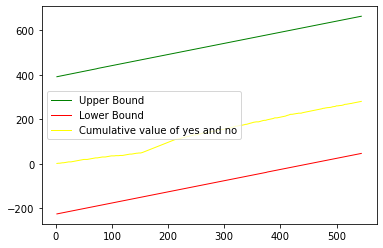

In [9]:
helper.plot_cumulative(upper_limit, lower_limit, r, x1)